In [275]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import river
from river import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.data import DataStream
from skmultiflow.meta import OnlineRUSBoostClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.meta import AccuracyWeightedEnsembleClassifier
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection import DDM






### Data preprocess

In [304]:
inc_data = arff.load('INSECTS-incremental_balanced_norm.arff')
inc_df = pd.DataFrame(list(inc_data))

inc_df = inc_df.replace(['ae-aegypti-male'], 0)
inc_df = inc_df.replace(['cx-quinq-male'], 1)
inc_df = inc_df.replace(['cx-quinq-female'], 2)
inc_df = inc_df.replace(['ae-aegypti-female'], 3)
inc_df = inc_df.replace(['ae-albopictus-female'], 4)
inc_df = inc_df.replace(['ae-albopictus-male'], 5)

inc_X = inc_df.iloc[:, 0:-1].to_numpy()
inc_y = inc_df.iloc[:, -1].to_numpy()

print(inc_X.shape)
print(inc_y.shape)
inc_n, inc_m = inc_X.shape

inc_stream = DataStream(data=inc_X, y=inc_y)


(57018, 33)
(57018,)


In [305]:
inc_abr_data = arff.load('INSECTS-abrupt_balanced_norm.arff')
inc_abr_df = pd.DataFrame(list(inc_abr_data))

inc_abr_df = inc_abr_df.replace(['ae-aegypti-male'], 0)
inc_abr_df = inc_abr_df.replace(['cx-quinq-male'], 1)
inc_abr_df = inc_abr_df.replace(['cx-quinq-female'], 2)
inc_abr_df = inc_abr_df.replace(['ae-aegypti-female'], 3)
inc_abr_df = inc_abr_df.replace(['ae-albopictus-female'], 4)
inc_abr_df = inc_abr_df.replace(['ae-albopictus-male'], 5)

inc_abr_X = inc_abr_df.iloc[:, 0:-1].to_numpy()
inc_abr_y = inc_abr_df.iloc[:, -1].to_numpy()

print(inc_abr_X.shape)
print(inc_abr_y.shape)
inc_abr_n, inc_abr_m = inc_abr_X.shape

inc_abr_stream = DataStream(data=inc_abr_X, y=inc_abr_y)

(52848, 33)
(52848,)


In [306]:
inc_gra_data = arff.load('INSECTS-gradual_balanced_norm.arff')
inc_gra_df = pd.DataFrame(list(inc_gra_data))

inc_gra_df = inc_gra_df.replace(['ae-aegypti-male'], 0)
inc_gra_df = inc_gra_df.replace(['cx-quinq-male'], 1)
inc_gra_df = inc_gra_df.replace(['cx-quinq-female'], 2)
inc_gra_df = inc_gra_df.replace(['ae-aegypti-female'], 3)
inc_gra_df = inc_gra_df.replace(['ae-albopictus-female'], 4)
inc_gra_df = inc_gra_df.replace(['ae-albopictus-male'], 5)

inc_gra_X = inc_gra_df.iloc[:, 0:-1].to_numpy()
inc_gra_y = inc_gra_df.iloc[:, -1].to_numpy()

print(inc_gra_X.shape)
print(inc_gra_y.shape)
inc_gra_n, inc_gra_m = inc_gra_X.shape

inc_gra_stream = DataStream(data=inc_gra_X, y=inc_gra_y)

(24150, 33)
(24150,)


### Classifiers and Training

In [279]:
def no_change_classifier(X, y):
    # X is a numpy array of shape (n_samples, n_features)
    # y is a numpy array of shape (n_samples,)
    # returns a numpy array of shape (n_samples,)
    y_true = []
    y_pred = []
    last_seen = -1
    correct_cnt, n_samples = 0, 0
    acc_list = []
    for xi, yi in zip(X, y):
        y_pred.append(last_seen)
        y_true.append(yi)
        if(yi == last_seen):
            correct_cnt+=1
        last_seen = yi
        n_samples+=1
        if(n_samples % 1000 == 0):
            acc_list.append(accuracy_score(y_true[-1000:], y_pred[-1000:]))
    return acc_list


In [280]:
def majority_class_classifier(X, y):
    # X is a numpy array of shape (n_samples, n_features)
    # y is a numpy array of shape (n_samples,)
    # returns a numpy array of shape (n_samples,)
    left, right = 0, 0
    cnt = [0, 0, 0, 0, 0, 0]
    maxY = 0
    maxCnt = 0
    correct_cnt = 0
    y_true = []
    y_pred = []
    acc_list = []
    while(right < len(y)):
        y_true.append(y[right])
        y_pred.append(maxY)

        cnt[y[right]] += 1
        for i in range(6):
            if(cnt[i] > maxCnt):
                maxCnt = cnt[i]
                maxY = i
        right += 1
        if(right % 1000 == 0):
            acc_list.append(accuracy_score(y_true[-1000:], y_pred[-1000:]))
        if(right - left > 1000):
            cnt[y[left]] -= 1
            left += 1

    return acc_list
    


In [281]:
def train(data_stream, classifier):
    if not data_stream.has_more_samples():
        print('restart stream')
        data_stream.restart()
        
    acc_list = []
    n_samples = 1000
    X, y = data_stream.next_sample(1000)

    classifier.partial_fit(X, y)
    y_pred = classifier.predict(X)
    
    while data_stream.has_more_samples():
        single_X, single_y = data_stream.next_sample()
        y_pred = np.append(y_pred, classifier.predict(single_X))
        X = np.append(X, single_X, axis=0)
        y = np.append(y, single_y)
        # y.append(single_y)
        if(n_samples % 1000 == 0):
            acc_list.append(accuracy_score(y[-1000:], y_pred[-1000:]))
        classifier.partial_fit(single_X, single_y)
        n_samples += 1
    return acc_list


In [282]:
ht = HoeffdingTreeClassifier()
knn = SAMKNNClassifier(n_neighbors=5)
hat = HoeffdingAdaptiveTreeClassifier()
awe = AccuracyWeightedEnsembleClassifier()
arf = AdaptiveRandomForestClassifier()

In [283]:
ht_inc_acc_list = train(inc_stream, ht)
knn_inc_acc_list = train(inc_stream, knn)
hat_inc_acc_list = train(inc_stream, hat)
awe_inc_acc_list = train(inc_stream, awe)
arf_inc_acc_list = train(inc_stream, arf)
no_change_inc_acc_list = no_change_classifier(inc_X, inc_y)
majority_class_inc_acc_list = majority_class_classifier(inc_X, inc_y)

restart stream
restart stream
restart stream
restart stream


In [284]:
ht_inc_abr_acc_list = train(inc_abr_stream, ht)
knn_inc_abr_acc_list = train(inc_abr_stream, knn)
hat_inc_abr_acc_list = train(inc_abr_stream, hat)
awe_inc_abr_acc_list = train(inc_abr_stream, awe)
arf_inc_abr_acc_list = train(inc_abr_stream, arf)
no_change_inc_abr_acc_list = no_change_classifier(inc_abr_X, inc_abr_y)
majority_class_inc_abr_acc_list = majority_class_classifier(inc_abr_X, inc_abr_y)

restart stream
restart stream
restart stream
restart stream


In [285]:
ht_inc_gra_acc_list = train(inc_gra_stream, ht)
knn_inc_gra_acc_list = train(inc_gra_stream, knn)
hat_inc_gra_acc_list = train(inc_gra_stream, hat)
awe_inc_gra_acc_list = train(inc_gra_stream, awe)
arf_inc_gra_acc_list = train(inc_gra_stream, arf)
no_change_inc_gra_acc_list = no_change_classifier(inc_gra_X, inc_gra_y)
majority_class_inc_gra_acc_list = majority_class_classifier(inc_gra_X, inc_gra_y)

restart stream
restart stream
restart stream
restart stream


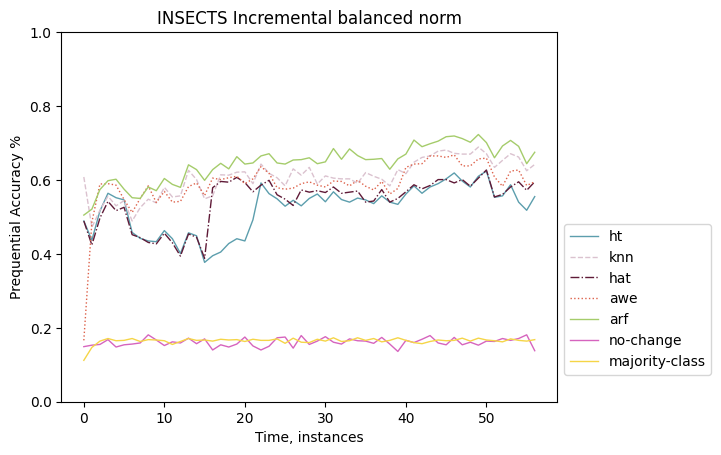

In [286]:
plt.title('INSECTS Incremental balanced norm')
plt.plot(ht_inc_acc_list, label='ht', linewidth=1, color='#5c9ead')
plt.plot(knn_inc_acc_list, label='knn', linewidth=1, linestyle='--', color='#dbc2cf')
plt.plot(hat_inc_acc_list, label='hat', linewidth=1, linestyle='-.', color='#5f1a37')
plt.plot(awe_inc_acc_list, label='awe', linewidth=1, linestyle=':', color='#dd614a')
plt.plot(arf_inc_acc_list, label='arf', linewidth=1, color='#a5cc6b')
plt.plot(no_change_inc_acc_list, label='no-change', linewidth=1, color='#d664be')
plt.plot(majority_class_inc_acc_list, label='majority-class', linewidth=1, color='#f5d547')
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()




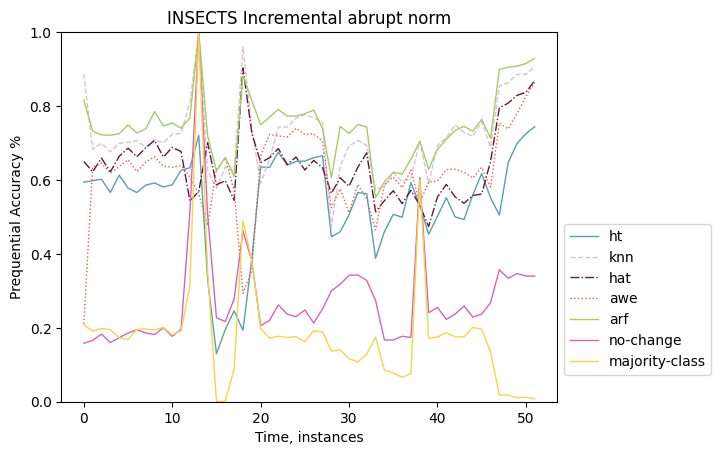

In [287]:
plt.title('INSECTS Incremental abrupt norm')
plt.plot(ht_inc_abr_acc_list, label='ht', linewidth=1, color='#5c9ead')
plt.plot(knn_inc_abr_acc_list, label='knn', linewidth=1, linestyle='--', color='#dbc2cf')
plt.plot(hat_inc_abr_acc_list, label='hat', linewidth=1, linestyle='-.', color='#5f1a37')
plt.plot(awe_inc_abr_acc_list, label='awe', linewidth=1, linestyle=':', color='#dd614a')
plt.plot(arf_inc_abr_acc_list, label='arf', linewidth=1, color='#a5cc6b')
plt.plot(no_change_inc_abr_acc_list, label='no-change', linewidth=1, color='#d664be')
plt.plot(majority_class_inc_abr_acc_list, label='majority-class', linewidth=1, color='#f5d547')
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()



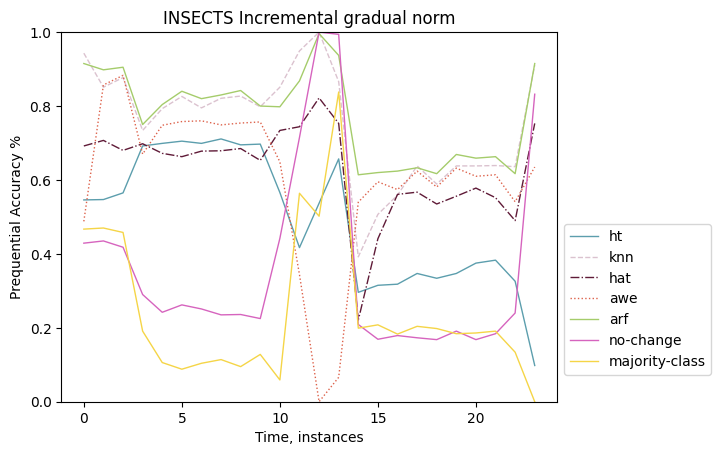

In [288]:
plt.title('INSECTS Incremental gradual norm')
plt.plot(ht_inc_gra_acc_list, label='ht', linewidth=1, color='#5c9ead')
plt.plot(knn_inc_gra_acc_list, label='knn', linewidth=1, linestyle='--', color='#dbc2cf')
plt.plot(hat_inc_gra_acc_list, label='hat', linewidth=1, linestyle='-.', color='#5f1a37')
plt.plot(awe_inc_gra_acc_list, label='awe', linewidth=1, linestyle=':', color='#dd614a')
plt.plot(arf_inc_gra_acc_list, label='arf', linewidth=1, color='#a5cc6b')
plt.plot(no_change_inc_gra_acc_list, label='no-change', linewidth=1, color='#d664be')
plt.plot(majority_class_inc_gra_acc_list, label='majority-class', linewidth=1, color='#f5d547')
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## Drift detection

In [318]:
def train_with_drift_detetion(data_stream, max_samples):
    ddm = DDM()
    ht = HoeffdingAdaptiveTreeClassifier()
    new_ht = None
    if not data_stream.has_more_samples():
        print('restart stream')
        data_stream.restart()

    dd_list = []    
    acc_list = []
    n_samples = 1000
    X, y = data_stream.next_sample(1000)

    y_pred = ht.predict(X)
    ht.partial_fit(X, y)

    detected = False
    while n_samples < max_samples and data_stream.has_more_samples():
        single_X, single_y = data_stream.next_sample()
        n_samples += 1

        res = ht.predict(single_X)
        y_pred = np.append(y_pred, res)
        X = np.append(X, single_X, axis=0)
        y = np.append(y, single_y)
        acc_list.append(accuracy_score(y[-1000:], y_pred[-1000:]))

        # ddm is only monitors 0's and 1's
        ddm.add_element( 0 if res[0] == single_y[0] else 1)

        if ddm.detected_warning_zone() and not detected:
            new_ht = HoeffdingAdaptiveTreeClassifier()
            detected = True
        
        if ddm.detected_change() and detected:
            dd_list.append(n_samples)
            ht = new_ht
            new_ht = None
            ddm.reset()
            detected = False


        ht.partial_fit(single_X, single_y)
        
        if new_ht:
            new_ht.partial_fit(single_X, single_y)
    return acc_list, dd_list


In [319]:
ht_inc_dd_acc_list, ht_inc_dd_list = train_with_drift_detetion(inc_stream, inc_n)
ht_inc_abr_dd_acc_list, ht_inc_abr_dd_list = train_with_drift_detetion(inc_abr_stream, inc_abr_n)
ht_inc_gra_dd_acc_list, ht_inc_gra_dd_list= train_with_drift_detetion(inc_gra_stream, inc_gra_n)

restart stream
restart stream
restart stream


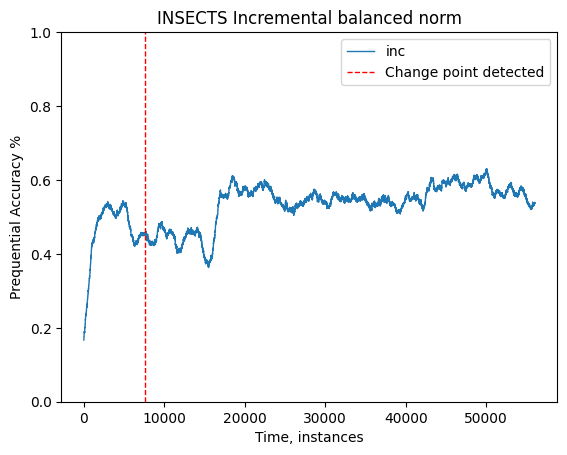

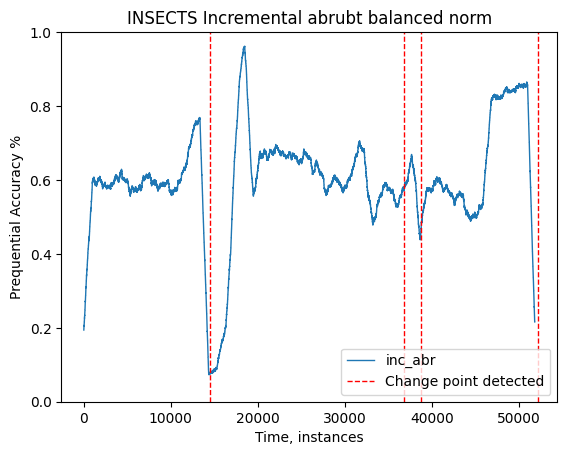

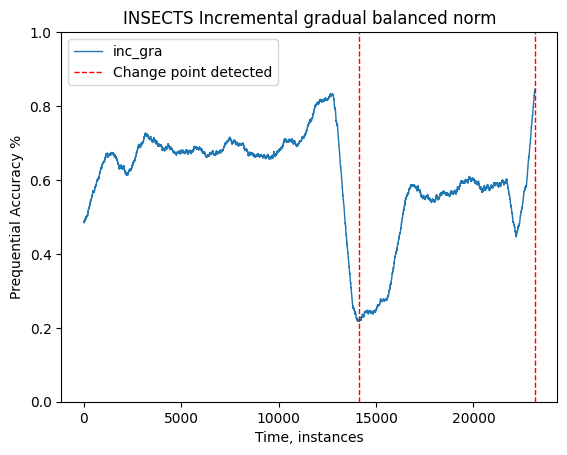

In [321]:
plt.title('INSECTS Incremental balanced norm')
plt.plot(ht_inc_dd_acc_list, label='inc', linewidth=1)
plt.axvline(x=ht_inc_dd_list[0], color='r', label='Change point detected', linestyle='--', linewidth=1)
for d in ht_inc_dd_list[1:]:
    plt.axvline(x=d, color='r', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()

plt.title('INSECTS Incremental abrubt balanced norm')
plt.plot(ht_inc_abr_dd_acc_list, label='inc_abr', linewidth=1)
plt.axvline(x=ht_inc_abr_dd_list[0], color='r', label='Change point detected', linestyle='--', linewidth=1)
for d in ht_inc_abr_dd_list[1:]:
    plt.axvline(x=d, color='r', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()

plt.title('INSECTS Incremental gradual balanced norm')
plt.plot(ht_inc_gra_dd_acc_list, label='inc_gra', linewidth=1)
plt.axvline(x=ht_inc_gra_dd_list[0], color='r', label='Change point detected', linestyle='--', linewidth=1)
for d in ht_inc_gra_dd_list[1:]:
    plt.axvline(x=d, color='r', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()



In [322]:
print('INSECTS Incremental balanced norm - ht:' + str(np.mean(ht_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - ht:' + str(np.mean(ht_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - ht:' + str(np.mean(ht_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - knn:' + str(np.mean(knn_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - knn:' + str(np.mean(knn_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - knn:' + str(np.mean(knn_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - hat:' + str(np.mean(hat_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - hat:' + str(np.mean(hat_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - hat:' + str(np.mean(hat_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - awe:' + str(np.mean(awe_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - awe:' + str(np.mean(awe_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - awe:' + str(np.mean(awe_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - arf:' + str(np.mean(arf_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - arf:' + str(np.mean(arf_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - arf:' + str(np.mean(arf_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - no-change:' + str(np.mean(no_change_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - no-change:' + str(np.mean(no_change_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - no-change:' + str(np.mean(no_change_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - mc:' + str(np.mean(majority_class_inc_acc_list)))
print('INSECTS Incremental abrupt balanced norm - mc:' + str(np.mean(majority_class_inc_abr_acc_list)))
print('INSECTS Incremental gradual balanced norm - mc:' + str(np.mean(majority_class_inc_gra_acc_list)))
print()

print('INSECTS Incremental balanced norm - ht:' + str(np.mean(ht_inc_dd_acc_list)))
print('INSECTS Incremental abrupt balanced norm - ht:' + str(np.mean(ht_inc_abr_dd_acc_list)))
print('INSECTS Incremental gradual balanced norm - ht:' + str(np.mean(ht_inc_gra_dd_acc_list)))


INSECTS Incremental balanced norm - ht:0.5221228070175439
INSECTS Incremental abrupt balanced norm - ht:0.5423846153846154
INSECTS Incremental gradual balanced norm - ht:0.49466666666666664

INSECTS Incremental balanced norm - knn:0.6069298245614037
INSECTS Incremental abrupt balanced norm - knn:0.7172307692307693
INSECTS Incremental gradual balanced norm - knn:0.75325

INSECTS Incremental balanced norm - hat:0.5432807017543859
INSECTS Incremental abrupt balanced norm - hat:0.6406346153846154
INSECTS Incremental gradual balanced norm - hat:0.62975

INSECTS Incremental balanced norm - awe:0.5885263157894736
INSECTS Incremental abrupt balanced norm - awe:0.6177307692307692
INSECTS Incremental gradual balanced norm - awe:0.6012083333333335

INSECTS Incremental balanced norm - arf:0.6451052631578946
INSECTS Incremental abrupt balanced norm - arf:0.74575
INSECTS Incremental gradual balanced norm - arf:0.7764166666666666

INSECTS Incremental balanced norm - no-change:0.16080701754385962
INSE